In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.stats.diagnostic as diag
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
# from statsmodels.stats.diagnostic import breusch_godfrey
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('C:/Users/dhruv/Documents/School/Time Series/code/finalData.csv', index_col='dates', parse_dates=True)
overall = df
overall = overall.drop(columns=['Top 10 Gross', 'Week', 'Overall Gross', 'cpi', 'realTop'])
overall

,realOverall,realpcedur
dates,,
2000-04-01,1.510867e+09,295.204400
2000-07-01,1.868981e+09,296.089255
2000-10-01,1.832493e+09,295.881454
2001-01-01,2.144246e+09,291.660926
2001-04-01,1.543015e+09,292.551492
...,...,...
2021-10-01,1.365130e+09,527.691809
2022-01-01,1.926702e+09,533.050852
2022-04-01,1.276852e+09,522.994216


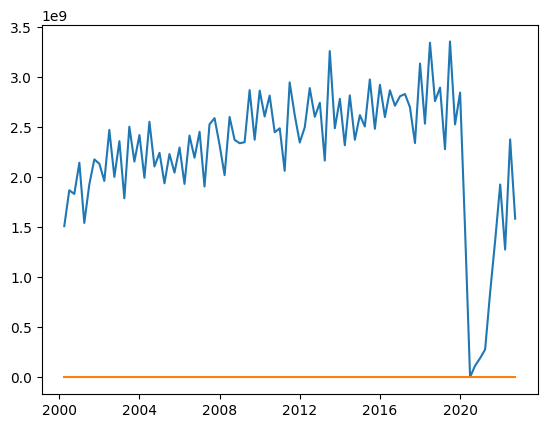

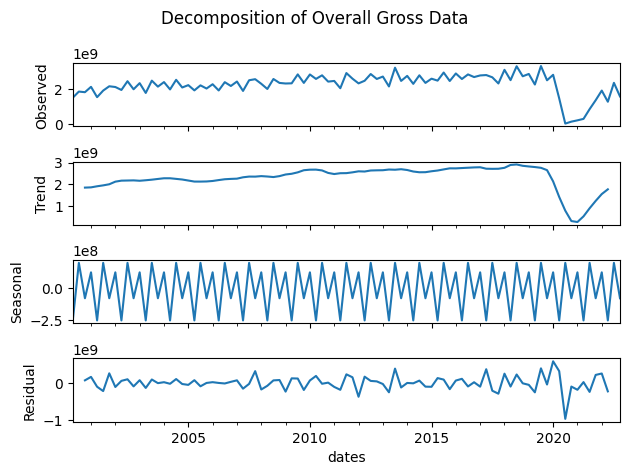

In [7]:
plt.plot(overall)
# Decompose the time series using an additive model
decomposition = seasonal_decompose(overall['realOverall'], model='additive')

# Plot the decomposed data
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
fig.suptitle('Decomposition of Overall Gross Data', fontsize=12)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Deseasonalized Time Series')

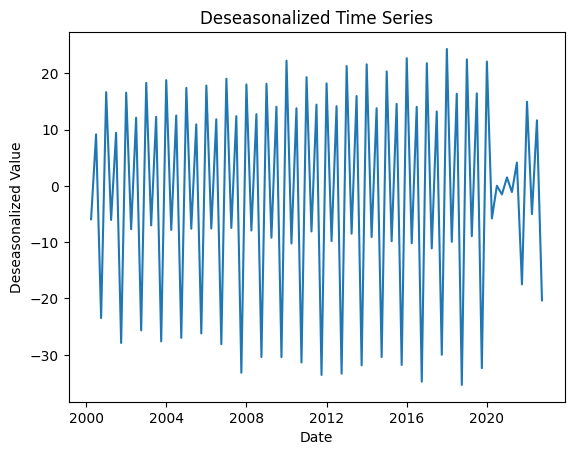

In [8]:
# Deseasonalize the data using the previously computed decomposition
deseasonalized = overall['realOverall'] / decomposition.seasonal

# Plot the deseasonalized time series 
fig, ax = plt.subplots()
ax.plot(deseasonalized)
ax.set_ylabel('Deseasonalized Value')
ax.set_xlabel('Date')
ax.set_title('Deseasonalized Time Series')

# Display the plot
# plt.show()


In [9]:
# Testing for unit root with the ADF test
# 'nc': no constant term, 'c': constant term only, ct': constant and linear trend
# lines up with the none, drift, and trend models in R
models = ['n', 'c', 'ct']
results = []
for model in models:
    result = adfuller(deseasonalized, regression=model, autolag='AIC', maxlag=10)
    results.append([model, result[0], result[1], result[4]['5%']])

# Print results in a table
results.append([model, result[0], result[1], result[4]['5%']])

# Print results in a table
headers = ['Model', 'ADF Statistic','p-value','5% Critical Value']
print(tabulate(results[:-1], headers=headers))


Model      ADF Statistic    p-value    5% Critical Value
-------  ---------------  ---------  -------------------
n               -1.18232   0.216623             -1.94482
c               -2.14228   0.227857             -2.89841
ct              -2.4019    0.37861              -3.46687


Model      ADF Statistic      p-value    5% Critical Value
-------  ---------------  -----------  -------------------
n               -4.69113  4.15287e-06             -1.94488
c               -4.72029  7.70689e-05             -2.89889
ct              -4.88078  0.000337291             -3.4676


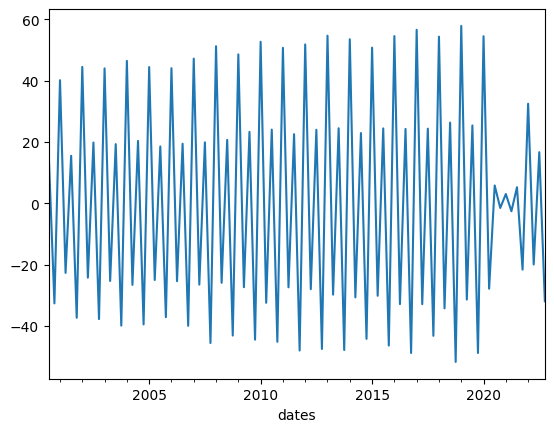

In [10]:
# Time series is non-stationary so we need to test for the unit root with first differences
stationary = deseasonalized.diff().dropna()
stationary.plot()
models = ['n', 'c', 'ct']
results = []
for model in models:
    result = adfuller(stationary, regression=model, autolag='AIC', maxlag=10)
    results.append([model, result[0], result[1], result[4]['5%']])

# Print results in a table
headers = ['Model', 'ADF Statistic', 'p-value', '5% Critical Value']
print(tabulate(results, headers=headers)) # data is now stationary

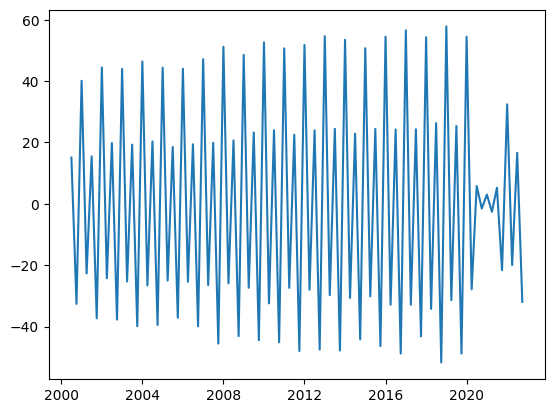

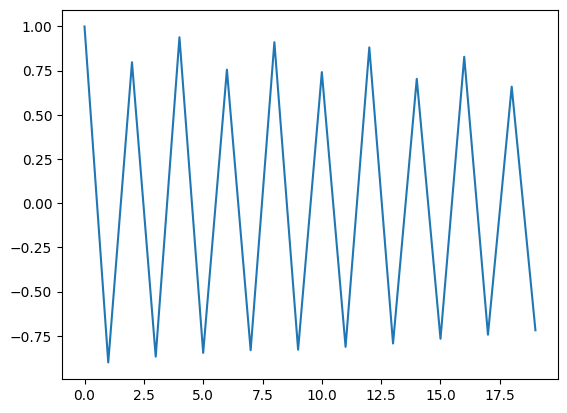

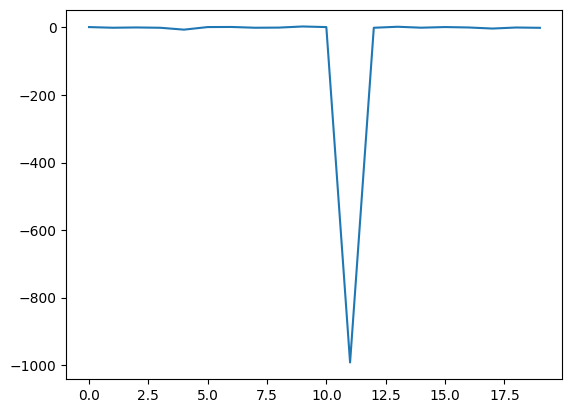

   lag         AIC         BIC
0    1  754.913575  762.413004
1    2  756.328075  766.327313
2    3  568.175503  580.674551
3    4  523.072311  538.071169
4    5  517.376502  534.875170
5    6  517.648512  537.646989
6    7  512.501487  534.999774
7    8  509.900198  534.898295


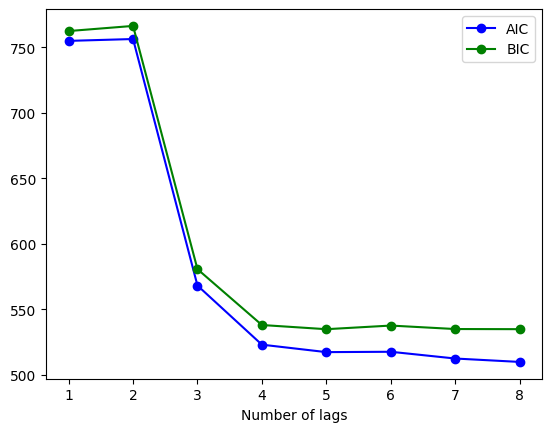

In [11]:
# Generate plots of the time series
plt.plot(stationary)
plt.show()
plt.plot(acf(stationary))
plt.show()
plt.plot(pacf(stationary))
plt.show()

# Select optimal number of lags using AIC and BIC
T = len(stationary)
pmax = 8
p = np.arange(1, pmax + 1)
aic = np.zeros(len(p))
bic = np.zeros(len(p))

for i in range(len(p)):
    model = ARIMA(stationary, order=(p[i], 0, 0)).fit()
    aic[i] = model.aic
    bic[i] = model.bic

select = pd.DataFrame({'lag': p, 'AIC': aic, 'BIC': bic})
print(select)

plt.plot(p, aic, 'bo-', label='AIC')
plt.plot(p, bic, 'go-', label='BIC')
plt.xlabel('Number of lags')
plt.legend()
plt.show()

In [12]:
# Generate plots of the time series
# plt.plot(stationary)
# plt.show()
# plt.plot(acf(stationary))
# plt.show()
# plt.plot(pacf(stationary))
# plt.show()

# Select optimal number of lags using auto_arima
model = auto_arima(stationary, start_p=1, start_q=1,
                   max_p=8, max_q=8, d=None, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True,
                   stepwise=True, information_criterion='aic')
print(model.summary())
print(model.aic())
print(model.bic())
# plt.plot(model.aic(), 'bo-', label='AIC')
# plt.plot(model.bic(), 'go-', label='BIC')
# plt.xlabel('Number of lags')
# plt.legend()
# plt.show()

model2 = auto_arima(stationary, start_p=1, start_q=1,
                   max_p=8, max_q=8, d=None, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True,
                   stepwise=True, information_criterion='bic')
print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=903.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=752.921, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=754.333, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=754.914, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -374.460
Date:                Sat, 08 Apr 2023   AIC                            752.921
Time:                        11:13:44   BIC                            757.920
Sample:                    07-01-2000   HQ

In [13]:
y = pd.Series(stationary)
final = ARIMA(y, order=(1, 0, 0)).fit()
forecast_values = final.forecast(steps=3)

print("Forecasted values:", forecast_values)

import statsmodels.api as sm

# Create a linear regression model object and obtain residuals
fe = sm.OLS(final.resid, np.ones_like(final.resid)).fit()

# Create two arrays of length 12 to store test statistics and p-values
a = np.zeros(12)
b = np.zeros(12)

# Loop over lags 1 to 12 and perform the Breusch-Godfrey test for each lag
for p in range(1, 13):
    bg = sm.stats.diagnostic.acorr_breusch_godfrey(fe, nlags=p)
    a[p-1] = bg[0]   # Store test statistic
    b[p-1] = bg[1]   # Store p-value

# Combine the results into a data frame
results = pd.DataFrame({'Lag': range(1, 13), 'Test Statistic': a, 'p-value': b})
print(results)   # Print the results


Forecasted values: 2023-01-01    28.645081
2023-04-01   -25.935435
2023-07-01    23.223886
Freq: QS-OCT, Name: predicted_mean, dtype: float64
    Lag  Test Statistic       p-value
0     1        0.746975  3.874356e-01
1     2       63.399808  1.709648e-14
2     3       81.609982  1.385659e-17
3     4       81.736125  7.466359e-17
4     5       81.751634  3.607939e-16
5     6       81.763874  1.543375e-15
6     7       82.495805  4.262455e-15
7     8       82.496707  1.534923e-14
8     9       82.497247  5.149190e-14
9    10       82.526857  1.602035e-13
10   11       82.835129  4.165368e-13
11   12       83.012479  1.095638e-12
